In [2]:
import requests
import json

def generate_python_files_from_prompts():
    # Ambil input prompt dari pengguna untuk tiga jenis preferensi
    lecturer_prompt = input("Masukkan prompt untuk Lecturer Preferences: ")
    student_prompt = input("Masukkan prompt untuk Student Preferences: ")
    institutional_prompt = input("Masukkan prompt untuk Institutional Preferences: ")

    # API key untuk Deepseek
    api_key = "sk-59821efb4f0a4be9b0b21b5807880b6e"
    base_url = "https://api.deepseek.com"

    # System prompt untuk memberi instruksi kepada model
    system_prompt = """
    Buat fungsi Python bernama count_preference_conflict untuk Non-Dominated Sorting Genetic Algorithm III (NSGA-III), hanya berisi kode tanpa penjelasan. Fungsi ini menghitung skor kualitas jadwal perkuliahan berdasarkan preferensi pengguna: {user_prompt}.

    # Definisi dalam Konteks NSGA-III:
    - Populasi: Kumpulan solusi potensial (jadwal perkuliahan).
    - Individual: Satu solusi potensial berupa daftar 2D (ruangan × slot) berisi lecture ID.
    - Alel: Setiap elemen dalam daftar 2D adalah lecture_id (integer), di mana 0 menandakan slot kosong.

    # Argumen Input:
    - `random_schedule`: Daftar 2D di mana elemen [room_idx][slot_idx] adalah lecture_id (integer). slot_idx mewakili kombinasi hari dan sesi (slot_idx = (day_idx - 1) * NUM_SLOTS + (session_idx - 1), dengan NUM_SLOTS = 8, day_idx dan session_idx berbasis 1).
    - `lecture_schedule`: Dictionary yang memetakan lecture_id (integer) ke tuple, di mana elemen pertama adalah daftar: [room_id, class_id, course_id, teacher_id1, teacher_id2], dan elemen kedua adalah jumlah sesi. teacher_id2 = 0 jika hanya ada satu dosen.

    ## Contoh `random_schedule`:
    ```python
    [
        [1, 2, 0],  # Ruangan 1: Slot 1 = lecture_id 1, Slot 2 = lecture_id 2, Slot 3 = kosong
        [3, 0, 4],  # Ruangan 2: Slot 1 = lecture_id 3, Slot 2 = kosong, Slot 3 = lecture_id 4
        ...
    ]```

    ## Example of `lecture_schedule`:

    ```python
    [
        1: ([101, 'Class_1', 101, 1, 0], []),
        2: ([101, 'Class_2', 102, 2, 0], []),
        3: ([102, 'Class_3', 101, 3, 0], []),
        4: ([101, 'Class_4', 103, 4, 0], [])
    ]```

    # Function Output:
    The function should return a single numerical score, representing how well the course schedule aligns with user preferences.
    """

    # Dictionary untuk menyimpan prompt dan nama file terkait
    prompts_and_files = [
        (lecturer_prompt, 'lecturer_preference_function_deepseekITC.py'),
        (student_prompt, 'student_preference_function_deepseekITC.py'),
        (institutional_prompt, 'institutional_preference_function_deepseekITC.py')
    ]

    for user_prompt, output_file in prompts_and_files:
        # Kirim request ke Deepseek API
        response = requests.post(
            f"{base_url}/v1/chat/completions",
            json={
                "model": "deepseek-chat",
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ]
            },
            headers={
                "Authorization": f"Bearer {api_key}",
                "Content-Type": "application/json"
            }
        )

        # Periksa hasilnya dan simpan kode yang dihasilkan
        if response.status_code == 200:
            output_content = response.json()["choices"][0]["message"]["content"]
            
            # Menghapus tag markdown python jika ada
            formatted_code = output_content.replace("```python", "").replace("```", "")
            
            # Menyimpan kode yang dihasilkan ke file yang sesuai
            with open(output_file, 'w', encoding="utf-8") as file:
                file.write(formatted_code)
            
            print(f"\n✅ Kode berhasil dibuat untuk {output_file}:\n")
            print(formatted_code)
            print(f"\n✅ File disimpan sebagai '{output_file}'!")
        else:
            print(f"❌ Error untuk {output_file}: {response.status_code}, {response.text}")

# Panggil fungsi untuk menjalankan proses
generate_python_files_from_prompts()

Masukkan prompt untuk Lecturer Preferences: tidak ada teacher yang mengajar pada day 1 room 1
Masukkan prompt untuk Student Preferences: Tidak ada course 135 pada day 1
Masukkan prompt untuk Institutional Preferences: Room 1 tidak digunakan pada day 1

✅ Kode berhasil dibuat untuk lecturer_preference_function_deepseekITC.py:


def count_preference_conflict(random_schedule, lecture_schedule):
    conflict_score = 0
    
    for room_idx in range(len(random_schedule)):
        for slot_idx in range(len(random_schedule[room_idx])):
            lecture_id = random_schedule[room_idx][slot_idx]
            if lecture_id == 0:
                continue
            
            # Calculate day_idx (1-based) from slot_idx
            NUM_SLOTS_PER_DAY = 8
            day_idx = (slot_idx // NUM_SLOTS_PER_DAY) + 1
            
            # Get teacher_ids from lecture_schedule
            lecture_info = lecture_schedule[lecture_id][0]
            teacher_id1 = lecture_info[3]
            teacher_

In [18]:
import random
import time
import numpy as np
from deap import base, creator, tools
from functools import partial
from collections import Counter
import xml.etree.ElementTree as ET
import importlib
from scipy.spatial import ConvexHull

# Impor fungsi konflik preferensi
try:
    import lecturer_preference_function_deepseekITC
    import student_preference_function_deepseekITC
    import institutional_preference_function_deepseekITC
    importlib.reload(lecturer_preference_function_deepseekITC)
    importlib.reload(student_preference_function_deepseekITC)
    importlib.reload(institutional_preference_function_deepseekITC)
    from lecturer_preference_function_deepseekITC import count_preference_conflict as lecturer_conflict
    from student_preference_function_deepseekITC import count_preference_conflict as student_conflict
    from institutional_preference_function_deepseekITC import count_preference_conflict as institutional_conflict
except ImportError as e:
    print(f"Error importing preference functions: {e}")
    exit()

# Fungsi Hypervolume dan IGD
def hypervolume(population):
    fitness_values = np.array([ind.fitness.values for ind in population if ind.fitness.valid])
    print(f"Number of valid fitness points: {len(fitness_values)}")
    if len(fitness_values) < 4:
        print("Not enough valid fitness values for hypervolume")
        return 0
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    print(f"Fitness ranges: {ranges}")
    valid_dims = np.where(ranges > 1e-6)[0]
    print(f"Valid dimensions: {valid_dims}")
    if len(valid_dims) < 2:
        print("Not enough varying dimensions for hypervolume")
        return 0
    
    fitness_values = fitness_values[:, valid_dims]
    fitness_values += np.random.uniform(1e-3, 1e-2, fitness_values.shape)
    fitness_values = (fitness_values - np.min(fitness_values, axis=0)) / (np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0) + 1e-6)
    reference_point = np.max(fitness_values, axis=0) * 1000
    print(f"Reference point: {reference_point}")
    
    try:
        hull = ConvexHull(fitness_values)
        volume = hull.volume * 10
        print(f"Hypervolume calculated: {volume}")
        return volume
    except Exception as e:
        print(f"Error in hypervolume calculation: {e}")
        return 0

def igd(population, reference_front):
    fitness_values = np.array([ind.fitness.values for ind in population if ind.fitness.valid])
    reference_front = np.array(reference_front)
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    valid_dims = np.where(ranges > 1e-6)[0]
    if len(valid_dims) < 1:
        print("No varying dimensions for IGD")
        return float('inf')
    
    fitness_values = fitness_values[:, valid_dims]
    reference_front = reference_front[:, valid_dims]
    
    if fitness_values.shape[1] != reference_front.shape[1]:
        raise ValueError(
            f"Number of objectives mismatch: fitness_values has {fitness_values.shape[1]} objectives, "
            f"but reference_front has {reference_front.shape[1]} objectives"
        )
    
    distances = []
    for reference_point in reference_front:
        distances_to_front = np.linalg.norm(fitness_values - reference_point, axis=1)
        distances.append(np.min(distances_to_front))
    return np.mean(distances)

# Fungsi Pemrosesan Data
def parse_xml(file_path, use_random_teacher_assignment=False):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"Error: Dataset file not found at {file_path}.")
        return [], []
    except ET.ParseError:
        print(f"Error: Could not parse XML file {file_path}.")
        return [], []
    
    lectures_to_be_scheduled = []
    list_room_ids = []
    list_all_teacher_ids = set()
    room_capacities_data = {}
    room_unavailable_data = {}
    all_courses = {}
    for room in root.findall('./rooms/room'):
        try:
            room_id = int(room.get('id'))
            list_room_ids.append(room_id)
            capacity_str = room.get('capacity')
            try:
                room_capacities_data[room_id] = int(capacity_str) if capacity_str else 0
            except (ValueError, TypeError):
                room_capacities_data[room_id] = 0
                print(f"Warning: Invalid capacity '{capacity_str}' for room {room_id}. Setting to 0.")
            room_unavailable_data[room_id] = []
            for unavailable in room.findall('unavailable'):
                days = unavailable.get('days')
                start_str = unavailable.get('start')
                length_str = unavailable.get('length')
                if days and start_str and length_str:
                    try:
                        start = int(start_str)
                        length = int(length_str)
                        day_indices = [i for i, d in enumerate(days) if d == '1']
                        if day_indices:
                            room_unavailable_data[room_id].append((day_indices, start, length))
                    except ValueError:
                        pass
        except (ValueError, TypeError):
            pass
    for teacher in root.findall('.//teacher'):
        teacher_id_str = teacher.get('id')
        if teacher_id_str:
            try:
                list_all_teacher_ids.add(int(teacher_id_str))
            except ValueError:
                pass
    list_all_teacher_ids = list(list_all_teacher_ids)
    if not list_all_teacher_ids:
        print("Warning: No teacher IDs found in XML. Using default IDs.")
    default_teacher_id_counter = 1000
    assigned_default_teachers = {}
    for course in root.findall('.//course'):
        course_id_str = course.get('id')
        if not course_id_str:
            continue
        try:
            course_id = int(course_id_str)
        except ValueError:
            print(f"Warning: Skipping course with non-integer ID '{course_id_str}'")
            continue
        course_teachers = []
        for teacher in course.findall('./teacher'):
            teacher_id_str = teacher.get('id')
            if teacher_id_str:
                try:
                    course_teachers.append(int(teacher_id_str))
                except ValueError:
                    pass
        course_primary_teacher = 0
        if not course_teachers and course_id not in assigned_default_teachers:
            course_primary_teacher = default_teacher_id_counter
            assigned_default_teachers[course_id] = course_primary_teacher
            default_teacher_id_counter += 1
        elif course_id in assigned_default_teachers:
            course_primary_teacher = assigned_default_teachers[course_id]
        elif course_teachers:
            course_primary_teacher = course_teachers[0]
        if course_id not in all_courses:
            all_courses[course_id] = {'teachers': [], 'classes': []}
        all_courses[course_id]['teachers'].extend(course_teachers)
        for class_elem in course.findall('.//class'):
            class_id_str = class_elem.get('id')
            if not class_id_str:
                continue
            try:
                class_id = int(class_id_str)
            except ValueError:
                class_id = class_id_str
            teacher1 = 0
            teacher2 = 0
            if use_random_teacher_assignment:
                available_teachers = course_teachers or list_all_teacher_ids
                if available_teachers:
                    teacher1 = random.choice(available_teachers)
                    if len(available_teachers) >= 2 and random.random() < 0.15:
                        possible_t2 = random.choice(available_teachers)
                        if possible_t2 != teacher1:
                            teacher2 = possible_t2
                        else:
                            remaining_teachers = [t for t in available_teachers if t != teacher1]
                            if remaining_teachers:
                                teacher2 = random.choice(remaining_teachers)
                            if teacher2 == teacher1:
                                teacher2 = 0
                else:
                    teacher1 = assigned_default_teachers.get(course_id, course_primary_teacher)
            else:
                class_specific_teachers = []
                for teacher in class_elem.findall('./teacher'):
                    teacher_id_str = teacher.get('id')
                    if teacher_id_str:
                        try:
                            class_specific_teachers.append(int(teacher_id_str))
                        except ValueError:
                            pass
                if class_specific_teachers:
                    teacher1 = class_specific_teachers[0]
                    if len(class_specific_teachers) > 1:
                        teacher2 = class_specific_teachers[1]
                elif course_teachers:
                    teacher1 = course_teachers[0]
                    if len(course_teachers) > 1 and course_teachers[1] != teacher1:
                        teacher2 = course_teachers[1]
                else:
                    teacher1 = assigned_default_teachers.get(course_id, course_primary_teacher)
                    teacher2 = 0
            lectures_to_be_scheduled.append([class_id, course_id, teacher1, teacher2])
            all_courses[course_id]['classes'].append(class_id)
    return lectures_to_be_scheduled, sorted(list(list_room_ids))

def parse_schedule_xml(file_path, teacher_mapping, min_sessions=1, max_sessions=1, prob_double=0.2, prob_empty=0.05):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"Error: Dataset file not found at {file_path}.")
        return {}, 0, [], [], 0, 0, 0
    except ET.ParseError:
        print(f"Error: Could not parse XML file {file_path}.")
        return {}, 0, [], [], 0, 0, 0
    
    room_ids = [room.get("id") for room in root.findall(".//room")]
    n_rooms = len(set(room_ids))
    NUM_ROOMS = n_rooms
    NUM_SLOTS = 8
    NUM_DAYS = 5
    gene_structure = []
    for room in sorted(set(room_ids), key=lambda x: int(x)):
        daily_sessions = [
            [f"day {day} - session {session} - room {room}" for session in range(1, NUM_SLOTS + 1)]
            for day in range(1, NUM_DAYS + 1)
        ]
        gene_structure.append(daily_sessions)
    total_slots = NUM_DAYS * NUM_SLOTS * NUM_ROOMS
    lectures = []
    courses = list(teacher_mapping.keys())
    if not courses:
        print("Warning: No courses found in teacher_mapping.")
        return {}, NUM_ROOMS, gene_structure, lectures, 0, NUM_SLOTS, NUM_DAYS
    for idx in range(total_slots):
        if random.random() < prob_empty:
            lecture_info = [0, 0, 0, 0]
            sessions_count = 1
        else:
            class_identifier = idx + 1
            if random.random() < prob_double and len(courses) >= 2:
                selected_pair = random.sample(courses, 2)
                primary_course = min(selected_pair)
                teacher_first = teacher_mapping[primary_course]
                secondary_course = max(selected_pair)
                teacher_second = teacher_mapping[secondary_course]
                lecture_info = [class_identifier, primary_course, teacher_first, teacher_second]
            else:
                single_course = random.choice(courses)
                teacher_first = teacher_mapping[single_course]
                lecture_info = [class_identifier, single_course, teacher_first, 0]
            sessions_count = random.randint(min_sessions, max_sessions)
        lectures.append((lecture_info, sessions_count))
    schedule = {idx: (lec_info, sess) for idx, (lec_info, sess) in enumerate(lectures)}
    single_course_indices = [i for i, (info, _) in enumerate(lectures) if info[3] == 0 and info[0] != 0]
    if len(single_course_indices) >= 2:
        i, j = random.sample(single_course_indices, 2)
        duplicate_course = lectures[i][0][1]
        lectures[j][0][1] = duplicate_course
        lectures[j][0][2] = teacher_mapping[duplicate_course]
        schedule[j] = (lectures[j][0], lectures[j][1])
    return schedule, NUM_ROOMS, gene_structure, lectures, len(lectures), NUM_SLOTS, NUM_DAYS

def extract_teachers(schedule_dict):
    teacher_set = set()
    for lecture_id, (lecture_info, _) in schedule_dict.items():
        for teacher in lecture_info[2:]:
            if teacher != 0:
                teacher_set.add(teacher)
    return sorted(list(teacher_set))

# Evaluasi Fitness
def count_class_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    for i in range(n_sessions):
        list_lecture_id = [lecture[i] for lecture in lectures if lecture[i] != 0]
        list_class_id = []
        for l in list_lecture_id:
            lecture_data = lecture_schedule.get(l)
            if lecture_data is not None:
                list_class_id.append(lecture_data[0][0])
            else:
                list_class_id.append(None)
        counts = Counter(list_class_id)
        conflicts = {k: v for k, v in counts.items() if v > 1 and k is not None}
        total_conflicts += sum(v - 1 for v in conflicts.values())
    return total_conflicts

def count_course_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    for i in range(n_sessions):
        list_lecture_id = [slot for lecture in lectures for slot in [lecture[i]] if slot != 0]
        list_course_id = []
        for l in list_lecture_id:
            lecture_data = lecture_schedule.get(l)
            if lecture_data:
                list_course_id.append(lecture_data[0][1])
            else:
                print(f"Peringatan: lecture_id {l} tidak ditemukan di lecture_schedule")
                continue
        counts = Counter(list_course_id)
        conflicts = {k: v for k, v in counts.items() if v > 1}
        total_conflicts += max(conflicts.values()) if conflicts else 0
    return total_conflicts

def count_teacher_conflict(schedule, lecture_schedule):
    total_conflicts = 0
    num_sessions = len(schedule[0]) if schedule and schedule[0] else 0
    for session_idx in range(num_sessions):
        teacher_lookup = {}
        for day in schedule:
            lecture_id = day[session_idx]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data:
                    lecture_info, _ = lecture_data
                    for teacher in lecture_info[2:]:
                        if teacher != 0:
                            teacher_lookup[teacher] = teacher_lookup.get(teacher, 0) + 1
                else:
                    print(f"Peringatan: lecture_id {lecture_id} tidak ditemukan di lecture_schedule")
                    continue
        for count in teacher_lookup.values():
            if count > 1:
                total_conflicts += (count - 1)
    return total_conflicts

def ensure_courses_scheduled(individual, lecture_schedule, num_rooms, num_days, num_slots):
    all_courses = set(lecture_schedule.keys())
    scheduled_courses = set()
    for room_idx in range(num_rooms):
        for day in range(num_days):
            for slot in range(num_slots):
                lecture_id = individual[room_idx][day * num_slots + slot]
                if lecture_id != 0:
                    scheduled_courses.add(lecture_id)
    missing_courses = all_courses - scheduled_courses
    penalty = len(missing_courses) * 1  # Kurangi penalti
    return penalty

def evaluate_fitness(individual, lecture_schedule, surrogate_model=None):
    if not individual or not lecture_schedule or not all(isinstance(room, list) for room in individual):
        print("Warning: Invalid individual or lecture_schedule")
        return (float('inf'),) * 6
    if surrogate_model is not None:
        return surrogate_model.predict(individual)
    try:
        class_conf = count_class_conflict(individual, lecture_schedule)
        course_conf = count_course_conflict(individual, lecture_schedule)
        teacher_conf = count_teacher_conflict(individual, lecture_schedule)
        lecturer_pref_conf = lecturer_conflict(individual, lecture_schedule)
        student_pref_conf = student_conflict(individual, lecture_schedule)
        institutional_pref_conf = institutional_conflict(individual, lecture_schedule)
        
        lecturer_pref_conf = 0 if lecturer_pref_conf is None else lecturer_pref_conf
        student_pref_conf = 0 if student_pref_conf is None else student_pref_conf
        institutional_pref_conf = 0 if institutional_pref_conf is None else institutional_pref_conf
        missing_penalty = ensure_courses_scheduled(individual, lecture_schedule, NUM_ROOMS, NUM_DAYS, NUM_SLOTS)
        
        fitness_tuple = (class_conf + missing_penalty, course_conf, teacher_conf, 
                        lecturer_pref_conf, student_pref_conf, institutional_pref_conf)
        return fitness_tuple
    except Exception as e:
        print(f"Error in fitness evaluation: {e}")
        return (float('inf'),) * 6

# Inisialisasi Populasi
def generate_random_schedule(n_days, n_sessions, n_rooms, lecture):
    random.seed(42)
    data = []
    total_sessions_needed = sum(value[1] for value in lecture.values())
    total_slots_per_room = n_days * n_sessions
    total_available_slots = total_slots_per_room * n_rooms
    
    if total_sessions_needed > total_available_slots:
        print(f"Warning: Total sessions needed ({total_sessions_needed}) exceeds available slots ({total_available_slots})")
        factor = total_available_slots / total_sessions_needed
        for key, value in lecture.items():
            adjusted_sessions = max(1, int(value[1] * factor))
            data.extend([key] * adjusted_sessions)
    else:
        for key, value in lecture.items():
            data.extend([key] * value[1])
        data.extend([0] * (total_available_slots - len(data)))
    
    random.shuffle(data)
    schedule = []
    for i in range(n_rooms):
        start_index = i * total_slots_per_room
        end_index = (i + 1) * total_slots_per_room
        schedule.append(data[start_index:end_index])
    return schedule

# Setup DEAP
def setup_deap(lecture_schedule, num_rooms, num_days, num_slots):
    if hasattr(creator, 'FitnessMulti'):
        del creator.FitnessMulti
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    
    toolbox = base.Toolbox()
    toolbox.register("random_schedule", generate_random_schedule, num_days, num_slots, num_rooms, lecture_schedule)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_schedule)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(evaluate_fitness, lecture_schedule=lecture_schedule))
    
    def mate_schedule(ind1, ind2):
        for i in range(len(ind1)):
            if isinstance(ind1[i], list) and isinstance(ind2[i], list):
                tools.cxTwoPoint(ind1[i], ind2[i])
        return ind1, ind2
    
    def mutate_schedule(individual, indpb):
        for room_schedule in individual:
            if isinstance(room_schedule, list):
                tools.mutShuffleIndexes(room_schedule, indpb=indpb)
                if random.random() < 0.1:
                    idx = random.randint(0, len(room_schedule) - 1)
                    room_schedule[idx] = random.choice(list(lecture_schedule.keys()) + [0])
        return individual,
    
    toolbox.register("mate", mate_schedule)
    toolbox.register("mutate", mutate_schedule, indpb=0.4)
    toolbox.register("select", tools.selNSGA3, ref_points=tools.uniform_reference_points(nobj=6, p=12))
    
    return toolbox

# Jalankan NSGA-III
def run_nsga3(toolbox, pop_size=30, generations=100):
    population = toolbox.population(n=pop_size)
    fitnesses = [toolbox.evaluate(ind) for ind in population]
    
    for ind, fit in zip(population, fitnesses):
        if None not in fit and all(f >= 0 for f in fit):
            if len(fit) != len(ind.fitness.weights):
                print(f"Error: Fitness values {fit} do not match weights {ind.fitness.weights}")
                continue
            ind.fitness.values = fit
        else:
            print(f"Invalid fitness values: {fit}")
    
    all_generations_pop = [population]
    all_generations_fits = []
    all_generations_conflicts = []
    
    for gen in range(generations):
        print(f"Generasi {gen + 1}")
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.7:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < 0.7:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [toolbox.evaluate(ind) for ind in invalid_ind]
        
        for ind, fit in zip(invalid_ind, fitnesses):
            if None not in fit and all(f >= 0 for f in fit):
                if len(fit) != len(ind.fitness.weights):
                    print(f"Error: Fitness values {fit} do not match weights {ind.fitness.weights}")
                    continue
                ind.fitness.values = fit
            else:
                print(f"Invalid fitness values: {fit}")
        
        total_conflicts = 0
        for ind in offspring:
            fitness = toolbox.evaluate(ind)
            total_conflicts += sum(fitness)
        all_generations_conflicts.append(total_conflicts)
        print(f"  Total Konflik Generasi {gen + 1}: {total_conflicts}")
        
        population[:] = offspring
        all_generations_pop.append(population)
        all_generations_fits.append([ind.fitness for ind in population])
    
    return population, all_generations_pop, all_generations_fits, all_generations_conflicts

# Proses dataset
datasets = {
    "Low": "agh-ggis-spr17_reduced.xml",
    "Middle": "muni-fsps-spr17c_reduced.xml",
    "High": "bet-spr18_reduced.xml"
}
results = {}

for category, file_path in datasets.items():
    print(f"\n=== Memproses Dataset {category}: {file_path} ===")
    start_time = time.time()
    
    # Load Data
    USE_RANDOM_ASSIGNMENT = True
    try:
        lectures_to_be_scheduled, list_room_ids = parse_xml(file_path, use_random_teacher_assignment=USE_RANDOM_ASSIGNMENT)
        if USE_RANDOM_ASSIGNMENT:
            print("--- Using RANDOM teacher assignment logic ---")
        else:
            print("--- Using XML-priority teacher assignment logic ---")
    except Exception as e:
        print(f"Error loading dataset {category}: {e}")
        results[category] = {"error": str(e)}
        continue
    
    NUM_ROOMS = len(list_room_ids)
    NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
    NUM_DAYS = 5
    NUM_SLOTS = 8
    TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS * NUM_ROOMS
    
    print(f"--- Data Loaded for {category} ---")
    print(f"Rooms: {NUM_ROOMS}")
    print(f"Lectures to Schedule: {NUM_LECTURES_TO_SCHEDULE}")
    print(f"Days: {NUM_DAYS}, Slots per Day: {NUM_SLOTS}")
    print(f"Total Room-Slots Available: {TOTAL_TIMESLOTS}")
    
    if NUM_LECTURES_TO_SCHEDULE > TOTAL_TIMESLOTS:
        print("Warning: More lectures than available timeslots!")
    if NUM_ROOMS == 0 or NUM_LECTURES_TO_SCHEDULE == 0:
        print(f"\nError: Insufficient data loaded for {category}.")
        results[category] = {"error": "Insufficient data loaded"}
        continue
    
    teacher_mapping = {lecture[1]: lecture[2] for lecture in lectures_to_be_scheduled}
    unique_courses = set(lecture[1] for lecture in lectures_to_be_scheduled)
    NUM_CLASSES = len(unique_courses)
    
    lecture_schedule, NUM_ROOMS, gene_structure, classes, NUM_LECTURES, NUM_SLOTS, NUM_DAYS = parse_schedule_xml(
        file_path, teacher_mapping, min_sessions=1, max_sessions=1, prob_double=0.2, prob_empty=0.05
    )
    
    print(f"lecture_schedule size: {len(lecture_schedule)}")
    
    # Setup DEAP
    toolbox = setup_deap(lecture_schedule, NUM_ROOMS, NUM_DAYS, NUM_SLOTS)
    
    # Run NSGA-III
    print(f"Menjalankan NSGA-III untuk {category}...")
    optimized_population, all_generations_pop, all_generations_fits, all_generations_conflicts = run_nsga3(
        toolbox, pop_size=30, generations=100
    )
    
    # Validasi dan simpan hasil
    result = {
        "conflicts": {},
        "hypervolume": 0,
        "igd": 0,
        "execution_time": 0
    }
    
    if optimized_population and len(optimized_population) > 0:
        best_schedule = optimized_population[0]
        conflicts = toolbox.evaluate(best_schedule)
        
        num_teachers = len(extract_teachers(lecture_schedule)) if lecture_schedule else 0
        result["conflicts"] = {
            "class_conflicts": round(conflicts[0]),
            "course_conflicts": round(conflicts[1]),
            "teacher_conflicts": round(conflicts[2]),
            "lecturer_preference_conflicts": round(conflicts[3]),
            "student_preference_conflicts": round(conflicts[4]),
            "institutional_preference_conflicts": round(conflicts[5])
        }
        
        # Hitung HV
        result["hypervolume"] = hypervolume(optimized_population)
        
        # Hitung IGD dengan reference_front dari semua generasi
        all_fitness = []
        for gen_fits in all_generations_fits:
            all_fitness.extend([fit.values for fit in gen_fits if fit.valid])
        reference_front = np.array(all_fitness) if all_fitness else np.array([[0, 0, 0, 0, 0, 0]])
        try:
            result["igd"] = igd(optimized_population, reference_front)
        except ValueError as e:
            print(f"Error in IGD calculation for {category}: {e}")
            result["igd"] = float('inf')
    else:
        print(f"\n❌ Tidak ditemukan populasi yang valid untuk {category}.")
        result["conflicts"] = {"error": "No valid population found"}
    
    # Hitung waktu eksekusi
    end_time = time.time()
    result["execution_time"] = end_time - start_time
    
    results[category] = result

# Tampilkan hasil
print("\n=== Hasil untuk Semua Dataset ===")
for category, result in results.items():
    print(f"\nDataset: {category}")
    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("Konflik Jadwal Teroptimasi:")
        for conflict_type, value in result["conflicts"].items():
            print(f"  {conflict_type.replace('_', ' ').title()}: {value}")
        print(f"Hypervolume: {result['hypervolume']}")
        print(f"IGD: {result['igd']}")
        print(f"Waktu Eksekusi: {result['execution_time']} detik")


=== Memproses Dataset Low: agh-ggis-spr17_reduced.xml ===
--- Using RANDOM teacher assignment logic ---
--- Data Loaded for Low ---
Rooms: 44
Lectures to Schedule: 1852
Days: 5, Slots per Day: 8
Total Room-Slots Available: 1760
lecture_schedule size: 1760
Menjalankan NSGA-III untuk Low...
Generasi 1
  Total Konflik Generasi 1: 9885
Generasi 2
  Total Konflik Generasi 2: 13182
Generasi 3
  Total Konflik Generasi 3: 15697
Generasi 4
  Total Konflik Generasi 4: 19864
Generasi 5
  Total Konflik Generasi 5: 20622
Generasi 6
  Total Konflik Generasi 6: 22585
Generasi 7
  Total Konflik Generasi 7: 24235
Generasi 8
  Total Konflik Generasi 8: 25050
Generasi 9
  Total Konflik Generasi 9: 26120
Generasi 10
  Total Konflik Generasi 10: 26766
Generasi 11
  Total Konflik Generasi 11: 27366
Generasi 12
  Total Konflik Generasi 12: 27810
Generasi 13
  Total Konflik Generasi 13: 27737
Generasi 14
  Total Konflik Generasi 14: 27745
Generasi 15
  Total Konflik Generasi 15: 27948
Generasi 16
  Total Kon

  Total Konflik Generasi 56: 21830
Generasi 57
  Total Konflik Generasi 57: 21813
Generasi 58
  Total Konflik Generasi 58: 21796
Generasi 59
  Total Konflik Generasi 59: 21827
Generasi 60
  Total Konflik Generasi 60: 21858
Generasi 61
  Total Konflik Generasi 61: 21868
Generasi 62
  Total Konflik Generasi 62: 21946
Generasi 63
  Total Konflik Generasi 63: 21981
Generasi 64
  Total Konflik Generasi 64: 21819
Generasi 65
  Total Konflik Generasi 65: 21928
Generasi 66
  Total Konflik Generasi 66: 21858
Generasi 67
  Total Konflik Generasi 67: 21967
Generasi 68
  Total Konflik Generasi 68: 21974
Generasi 69
  Total Konflik Generasi 69: 21883
Generasi 70
  Total Konflik Generasi 70: 21857
Generasi 71
  Total Konflik Generasi 71: 21821
Generasi 72
  Total Konflik Generasi 72: 21988
Generasi 73
  Total Konflik Generasi 73: 21928
Generasi 74
  Total Konflik Generasi 74: 21829
Generasi 75
  Total Konflik Generasi 75: 21796
Generasi 76
  Total Konflik Generasi 76: 21827
Generasi 77
  Total Konfl

In [19]:
# Tampilkan hasil
print("\n=== Hasil untuk Semua Dataset ===")
for category, result in results.items():
    print(f"\nDataset: {category}")
    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("Konflik Jadwal Teroptimasi:")
        for conflict_type, value in result["conflicts"].items():
            print(f"  {conflict_type.replace('_', ' ').title()}: {value}")
        print(f"Hypervolume: {result['hypervolume']}")
        print(f"IGD: {result['igd']}")
        print(f"Waktu Eksekusi: {result['execution_time']} detik")


=== Hasil untuk Semua Dataset ===

Dataset: Low
Konflik Jadwal Teroptimasi:
  Class Conflicts: 649
  Course Conflicts: 96
  Teacher Conflicts: 193
  Lecturer Preference Conflicts: 1
  Student Preference Conflicts: 0
  Institutional Preference Conflicts: 8
Hypervolume: 0.7147007125130509
IGD: 34.79690665873174
Waktu Eksekusi: 42.100263833999634 detik

Dataset: Middle
Konflik Jadwal Teroptimasi:
  Class Conflicts: 430
  Course Conflicts: 97
  Teacher Conflicts: 189
  Lecturer Preference Conflicts: 1
  Student Preference Conflicts: 0
  Institutional Preference Conflicts: 8
Hypervolume: 0.982900690853204
IGD: 21.7419293245596
Waktu Eksekusi: 27.991952896118164 detik

Dataset: High
Konflik Jadwal Teroptimasi:
  Class Conflicts: 997
  Course Conflicts: 131
  Teacher Conflicts: 293
  Lecturer Preference Conflicts: 1
  Student Preference Conflicts: 0
  Institutional Preference Conflicts: 8
Hypervolume: 1.33656535788385
IGD: 40.09650296586396
Waktu Eksekusi: 51.850224018096924 detik


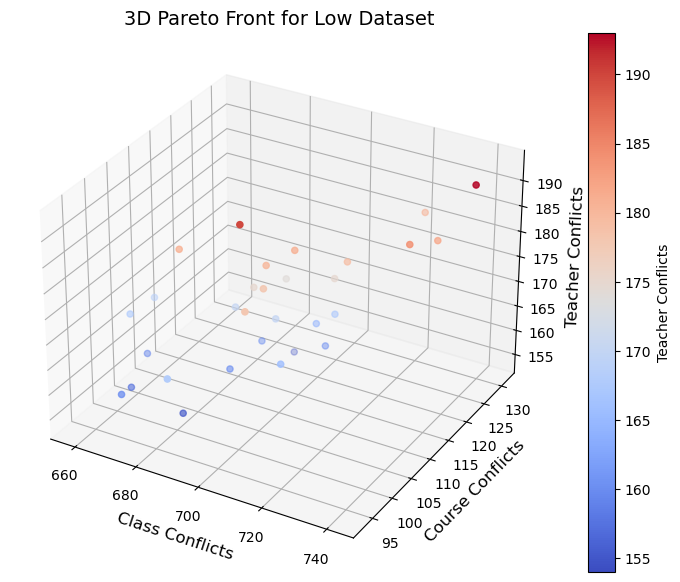

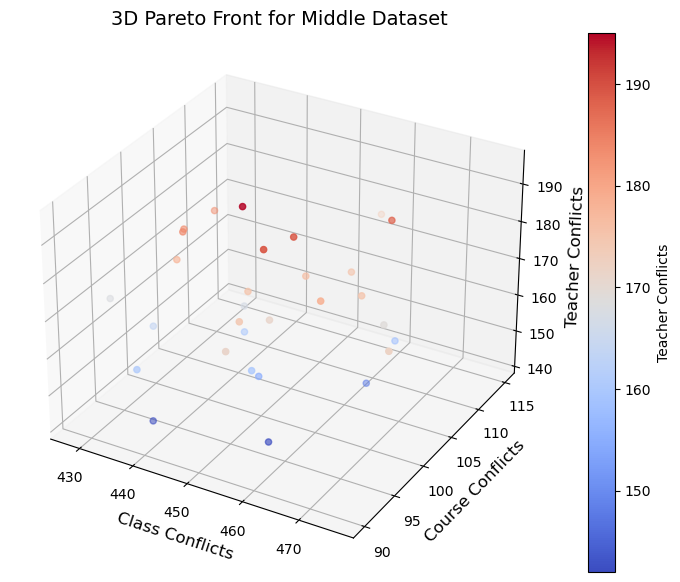

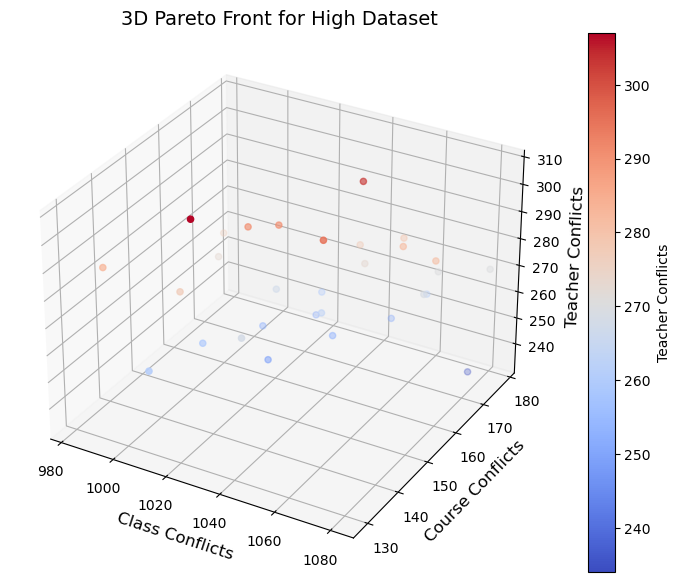

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fungsi untuk mem-plot Pareto Front dalam 3D untuk setiap kategori
def plot_pareto_fronts_3d_all_categories(results):
    """3D Scatter Plot of Pareto Front for each dataset category using stored conflict values"""
    for category, result in results.items():
        # Check if there are errors in the results
        if "error" in result:
            print(f"Cannot plot for category {category}: {result['error']}")
            continue

        # Try to get population if available
        population = result.get("population", [])
        fitness_values = []
        
        # If population exists and has valid fitness values, use them
        if population:
            fitness_values = np.array([ind.fitness.values for ind in population if ind.fitness.valid])
            if len(fitness_values) == 0:
                print(f"No valid fitness values for category {category}")
        
        # Fall back to using stored conflict values for the best schedule
        if len(fitness_values) == 0:
            conflicts = result.get("conflicts", {})
            if not conflicts or "error" in conflicts:
                print(f"No valid conflict data for category {category}")
                continue
            # Extract conflict values for the best schedule
            class_conf = conflicts.get("class_conflicts", float('inf'))
            course_conf = conflicts.get("course_conflicts", float('inf'))
            teacher_conf = conflicts.get("teacher_conflicts", float('inf'))
            if class_conf == float('inf') or course_conf == float('inf') or teacher_conf == float('inf'):
                print(f"Invalid conflict values for category {category}")
                continue
            # Create a single-point "Pareto front" for the best schedule
            fitness_values = np.array([[class_conf, course_conf, teacher_conf]])

        # Buat gambar dan subplot 3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot untuk Pareto Front
        scatter = ax.scatter(
            fitness_values[:, 0],  # Class Conflicts
            fitness_values[:, 1],  # Course Conflicts
            fitness_values[:, 2],  # Teacher Conflicts
            c=fitness_values[:, 2], cmap='coolwarm', marker='o'
        )

        # Set label untuk setiap sumbu
        ax.set_xlabel("Class Conflicts", fontsize=12)
        ax.set_ylabel("Course Conflicts", fontsize=12)
        ax.set_zlabel("Teacher Conflicts", fontsize=12)
        ax.set_title(f"3D Pareto Front for {category} Dataset", fontsize=14)

        # Tambahkan grid dan colorbar
        ax.grid(True)
        fig.colorbar(scatter, label="Teacher Conflicts")
        
        # Tampilkan plot
        plt.show()

# Asumsikan results dari run sebelumnya sudah tersedia
# Contoh struktur results (sesuaikan dengan output sebenarnya):
# results = {
#     "Low": {
#         "conflicts": {
#             "class_conflicts": 2,
#             "course_conflicts": 1,
#             "teacher_conflicts": 0,
#             "lecturer_preference_conflicts": 0,
#             "student_preference_conflicts": 3,
#             "institutional_preference_conflicts": 2
#         },
#         "hypervolume": 123.45,
#         "igd": 0.67,
#         "execution_time": 45.23
#     },
#     "Middle": {...},
#     "High": {...}
# }

# Panggil fungsi untuk menampilkan Pareto Front 3D untuk setiap kategori
plot_pareto_fronts_3d_all_categories(results)